In [63]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [64]:
# константы
#  ядро для генератора случайных чисел
my_seed = 12
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

C:\Users\Ирина\AppData\Local\Temp\ipykernel_11916\1994683459.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


## Загружаем данные

Набор данных `insurance` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/insurance.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные. 

In [65]:
# читаем таблицу из файла .csv во фрейм
fileURL = "https://raw.githubusercontent.com/ania607/ML/main/data/Carseats.csv"
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (400, 11)


In [66]:
# первые 5 строк фрейма
DF_raw.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [67]:
# типы столбцов фрейма
DF_raw.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

In [68]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [69]:
# кодируем категориальные переменные
#  городской
urban_dict = {'Yes':1,'No':0}
DF_raw['urbanYes'] = DF_raw.Urban.map(urban_dict)

#  us
us_dict = {'Yes':1,'No':0}
DF_raw['ucYes'] = DF_raw.US.map(us_dict)

# находим уникальные качества стеллажа для размещения автокресел в каждом магазине (далее "качества стеллажа")
DF_raw['ShelveLoc'].unique()

array(['Bad', 'Good', 'Medium'], dtype=object)

In [70]:
#  добавляем фиктивные на качество стелажжа : число фиктивных = число уникальных - 1
df_dummy = pd.get_dummies(DF_raw[['ShelveLoc']], drop_first=True)
df_dummy.head()

,ShelveLoc_Good,ShelveLoc_Medium
0,0,0
1,1,0
2,0,1
3,0,1
4,0,0


In [71]:
# объединяем с исходным фреймом
DF_all = pd.concat([DF_raw.reset_index(drop=True), df_dummy], axis=1)

# сколько теперь столбцов
DF_all.shape

(400, 15)

In [72]:
# смотрим первые 8 столбцов
DF_all.iloc[:,:8].head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age
0,9.50,138,73,11,276,120,Bad,42
1,11.22,111,48,16,260,83,Good,65
2,10.06,113,35,10,269,80,Medium,59
3,7.40,117,100,4,466,97,Medium,55
4,4.15,141,64,3,340,128,Bad,38


In [73]:
# смотрим последние 5 столбцов
DF_all.iloc[:,8:].head(5)

,Education,Urban,US,urbanYes,ucYes,ShelveLoc_Good,ShelveLoc_Medium
0,17,Yes,Yes,1,1,0,0
1,10,Yes,Yes,1,1,1,0
2,12,Yes,Yes,1,1,0,1
3,14,Yes,Yes,1,1,0,1
4,13,Yes,No,1,0,0,0


In [74]:
# оставляем в наборе данных только то, что нужно 
#  (плюс метки регионов для графиков)
DF_all = DF_all[['Sales','Income','Price','ShelveLoc','ShelveLoc_Good',
                 'ShelveLoc_Medium']]

# перекодируем регион в числовой фактор, 
#  чтобы использовать на графиках
class_le = LabelEncoder()
DF_all['ShelveLoc'] = class_le.fit_transform(DF_all.ShelveLoc.values)

DF_all.columns

Index(['Sales', 'Income', 'Price', 'ShelveLoc', 'ShelveLoc_Good',
       'ShelveLoc_Medium'],
      dtype='object')

In [75]:
DF_all.dtypes

Sales               float64
Income                int64
Price                 int64
ShelveLoc             int32
ShelveLoc_Good        uint8
ShelveLoc_Medium      uint8
dtype: object

In [76]:
# удаляем фрейм-исходник
del DF_raw

In [77]:
# данные для построения моделей
DF = DF_all.sample(frac=0.8, random_state = my_seed)
# данные для прогнозов
DF_predict=DF_all.drop(DF.index)

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что все показатели положительны.  

In [78]:
# описательные статистики для непрерывных переменных
DF[['Sales','Income','Price']].describe()

,Sales,Income,Price
count,320.000000,320.000000,320.000000
mean,7.536812,68.490625,115.762500
std,2.840746,28.206025,24.133767
min,0.000000,21.000000,24.000000
25%,5.527500,43.500000,100.000000
50%,7.545000,68.500000,117.000000
75%,9.332500,91.250000,131.000000
max,16.270000,120.000000,191.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

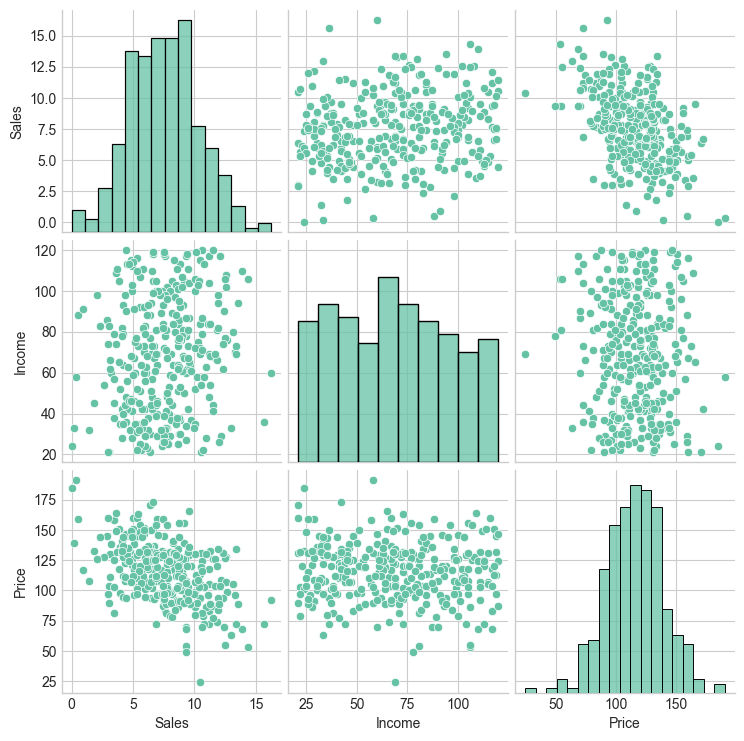

In [79]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Sales','Income','Price']])
plt.show()

Судя по этим графикам:  
* все данные имеют нормальное или близкое к нормальному распределение;  
* между `Price`и `Sales` прослеживается обратная зависимость`;  

Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из фиктивных объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от качеств стелажжа.  

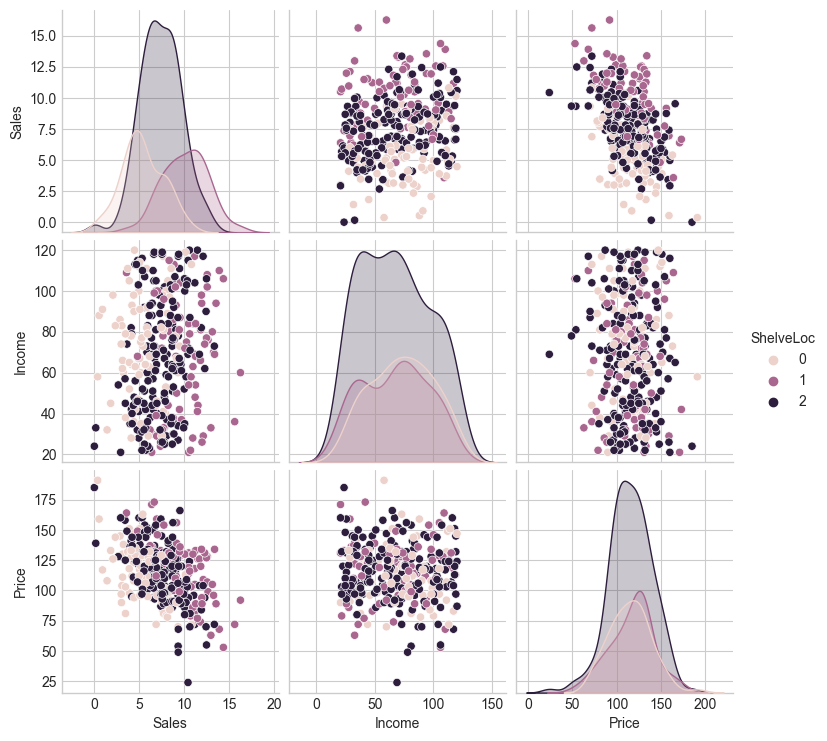

In [80]:
# матричный график разброса с цветом по качеству стелажжа
sns.pairplot(DF[['Sales','Income','Price','ShelveLoc']],
            hue='ShelveLoc')

plt.show()

Нарисуем график отдельно по ShelveLoc_Good.

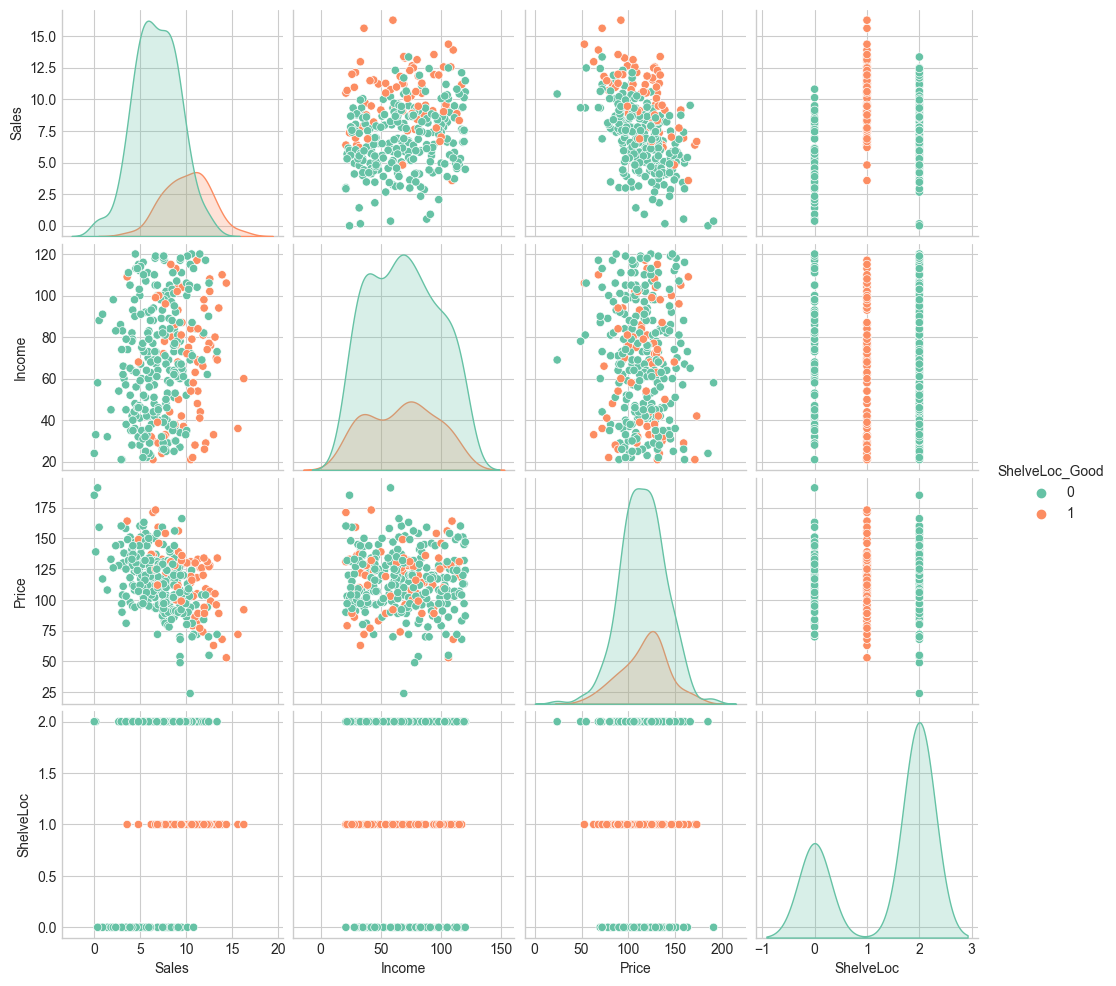

In [81]:
sns.pairplot(DF[['Sales','Income','Price','ShelveLoc', 
                 'ShelveLoc_Good']], hue='ShelveLoc_Good')
plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма.

In [82]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Sales','Income','Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\Ирина\AppData\Local\Temp\ipykernel_11916\633758650.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,Sales,Income,Price
Sales,1.00,0.16,-0.48
Income,0.16,1.00,-0.07
Price,-0.48,-0.07,1.00


In [83]:
# корреляционная матрица по классу хорошоее качество стелажжа
corr_mat = DF.loc[DF['ShelveLoc_Good'] == 1][['Sales','Income','Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

C:\Users\Ирина\AppData\Local\Temp\ipykernel_11916\2857063636.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,Sales,Income,Price
Sales,1.000000,0.114016,-0.675859
Income,0.114016,1.000000,0.016852
Price,-0.675859,0.016852,1.000000


In [84]:
# корреляционная матрица по классу среднее качество стелажжа
corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 1][['Sales','Income','Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

C:\Users\Ирина\AppData\Local\Temp\ipykernel_11916\3643428528.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,Sales,Income,Price
Sales,1.000000,0.315678,-0.593833
Income,0.315678,1.000000,-0.123839
Price,-0.593833,-0.123839,1.000000


In [86]:
# корреляционная матрица по классу плохое качество стелажжа
#corr_mat = DF.loc[DF[(['ShelveLoc_Medium'] == 0) and (['ShelveLoc_Good'] == 0)][['Sales','Income','Price']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

### Проведём формальные тесты на нормальность  

In [87]:
# тестируем на нормальность
for col in ['Sales']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Sales Statistics=1.00, p=0.6815
Распределение нормально (H0 не отклоняется)



## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Income + \hat{\beta_2} \cdot Price + \hat{\beta_3} \cdot ShelveLoc$
1. `fit_lm_2`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Price$
1. `fit_lm_3`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Price + \hat{\beta_2} \cdot Income$
1. `fit_lm_4`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Income + \hat{\beta_2} \cdot ShelveLoc \cdot Price$
1. `fit_lm_4`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Income$



### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [88]:
# данные для модели 1
df1 = DF[['Sales','Income','Price','ShelveLoc']]

# данные для модели 2
df2 = DF[['Sales','Price']]

# данные для модели 3
df3 = DF[['Sales','Price','Income']]

# данные для модели 4
df4 = DF[['Sales','Income','Price','ShelveLoc']]
df4.loc[:, 'Price_ShelveLoc'] = df4.loc[:,'Price']*df4.loc[:,'ShelveLoc']
df4 = df4.drop(['Price','ShelveLoc'], axis=1)

# данные для модели 5
df5 = DF[['Sales','Income']]

C:\Users\Ирина\AppData\Local\Temp\ipykernel_11916\2830848825.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.loc[:, 'Price_ShelveLoc'] = df4.loc[:,'Price']*df4.loc[:,'ShelveLoc']


In [89]:
# проверка результатов
df1.head()

,Sales,Income,Price,ShelveLoc
280,2.86,86,145,0
387,8.67,73,115,2
313,9.33,81,54,2
1,11.22,48,83,1
35,11.07,84,96,2


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `Sales` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [90]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df1.drop(['Sales'], axis=1)
y = df1.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)
print('модель fit_lm_1:\n', 
      'константа ', np.around(fit_lm_1.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_1:
 константа  [12.078] 
 объясняющие  ['Income', 'Price', 'ShelveLoc'] 
 коэффициенты  [[ 0.014 -0.055  0.667]]


In [91]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_1.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([2.4089022])

In [92]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df2.drop(['Sales'], axis=1)
y = df2.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)
print('модель fit_lm_2:\n', 
      'константа ', np.around(fit_lm_1.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_2:
 константа  [14.018] 
 объясняющие  ['Price'] 
 коэффициенты  [[-0.056]]


In [93]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df3.drop(['Sales'], axis=1)
y = df3.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)
print('модель fit_lm_3:\n', 
      'константа ', np.around(fit_lm_1.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_3:
 константа  [13.044] 
 объясняющие  ['Price', 'Income'] 
 коэффициенты  [[-0.055  0.012]]


In [94]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df4.drop(['Sales'], axis=1)
y = df4.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)
print('модель fit_lm_4:\n', 
      'константа ', np.around(fit_lm_1.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_4:
 константа  [6.283] 
 объясняющие  ['Income', 'Price_ShelveLoc'] 
 коэффициенты  [[0.016 0.001]]


In [95]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df5.drop(['Sales'], axis=1)
y = df5.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)
print('модель fit_lm_5:\n', 
      'константа ', np.around(fit_lm_1.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_5:
 константа  [6.447] 
 объясняющие  ['Income'] 
 коэффициенты  [[0.016]]


### Оценка точности

#### Перекрёстная проверка по блокам     

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [100]:
# Перекрёстная проверка по 5 блокам
folds = 5

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 4)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df1,df2,df3,df4,df5] :
    X = df.drop(['Sales'],axis=1)
    y = df.Sales
    kf_5 = KFold(n_splits=folds, random_state=r_state[i-1],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_5,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 5 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 5 блокам заняли 0.15 секунд


Вычислим ошибки для моделей на исходных значениях `Sales.  

In [101]:
scores

[-6.0228869467690105,
 -6.267030595763456,
 -6.2552200204345265,
 -7.917406161273713,
 -8.019799143134467]

In [102]:
[np.around(-x, 2) for x in scores]

[6.02, 6.27, 6.26, 7.92, 8.02]

Определим самые точные модели отдельно на `Sales` 

In [103]:
# самая точная на Sales
fits = ['fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4', 'fit_lm_5']
print('Наименьшая ошибка на тестовой с k-fold5 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf5 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold5 у модели fit_lm_1 :
MSE_kf5 = 6.0


Самой точной среди моделей для 'Sales' оказалась 'fit_lm_1'. Оценим точность прогноза по модели на отложенные наблюдения.

In [104]:
# прогноз по fit_lm_3
#  модель на всех обучающих наблюдениях
X = df1.drop(['Sales'], axis=1)
y = df1.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Sales']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['Income','Price','ShelveLoc']]
#  прогнозы
y_pred = fit_lm_1.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_1 на отложенных наблюдениях = 6.91


# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  